Forecasts should outperform the following "null models":

 - Feed-forward: predicted mortality is the most recent observation in each pixel.
 - Average: predicted mortality is the mean of observed values in the pixel.

We will have to be a little creative to get these to work in the torch framework.

In [1]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
import torch
import torchmetrics
from tqdm import tqdm

import os
try:
    import util
except ImportError:
    os.chdir("..")
finally:
    import util

/home/jovyan/ForestLST/util/__init__.py:13: UserWarning: PyTorch not found! Module util.training will not be loaded.
  warnings.warn("PyTorch not found! Module util.training will not be loaded.")


In [8]:
# Prepare data
# Ignore total BA calculation because we don't use those at all here.

ds = xr.open_dataset("data_working/westmort.nc")

ds["mort_ewma"] = xr.apply_ufunc(
    util.manip.numpy_ewma_vectorized,
    ds.mortality,
    input_core_dims=[["time"]],
    output_core_dims=[["time"]],
    vectorize=True,
    kwargs=dict(window=3)
)

years = ds.time.values

train_years = years[16:]
valid_years = years[:8]
test_years = years[8:16]

print("Training years:", train_years)
print("Validation years:", valid_years)
print("Testing years:", test_years)

Training years: [2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023]
Validation years: [1997 1998 1999 2000 2001 2002 2003 2004]
Testing years: [2005 2006 2007 2008 2009 2010 2011 2012]


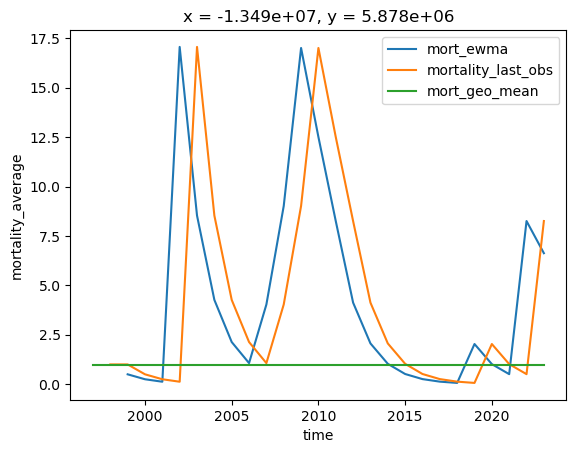

In [12]:
# Geometric mean over time of the training set
def safe_geometric_mean(arr, dim):
    # Prevent -Inf
    arr = (arr / 100) + 1e-3
    
    arr_log = np.log(arr)
    arr_log_mean = arr_log.mean(dim=dim)
    return (np.exp(arr_log_mean) - 1e-3) * 100
    
ds["mortality_average"]  = safe_geometric_mean(ds.sel(time=train_years).mort_ewma, ("time"))

# Last valid observation in a cell
ds["mortality_last_obs"] = ds.mort_ewma.ffill(dim="time").shift(time=1)

fig, ax = plt.subplots()

ds.isel(x=100, y=100).mort_ewma.plot(ax=ax, label="mort_ewma")
ds.isel(x=100, y=100).mortality_last_obs.plot(ax=ax, label="mortality_last_obs")
ds.isel(x=100, y=100).mortality_average.expand_dims(time=ds.time).plot(ax=ax, label="mort_geo_mean")

ax.legend()
plt.show()

In [15]:
# Use the same setup as when we train the convnets
window = dict(x=[8, False], y=[8, False], time=[5, False])
valid_wds = util.datasets.WindowXarrayDataset(ds.sel(time=valid_years), window, mask="mort_ewma")
test_wds  = util.datasets.WindowXarrayDataset(ds.sel(time=test_years), window, mask="mort_ewma")

print("N valid", len(valid_wds))
print("N test", len(test_wds))

N valid 8361
N test 22516


In [16]:
# Windows have the "null models" already associated so we can just iterate
# over and calculate metrics.
w = valid_wds[10]
w

<xarray.Dataset> Size: 23kB
Dimensions:             (time: 5, x: 8, y: 8)
Coordinates:
  * time                (time) int64 40B 1999 2000 2001 2002 2003
  * x                   (x) float64 64B -1.306e+07 -1.305e+07 ... -1.303e+07
  * y                   (y) float64 64B 6.27e+06 6.266e+06 ... 6.242e+06
Data variables: (12/20)
    abies               (time, y, x) float32 1kB ...
    picea               (time, y, x) float32 1kB ...
    populus             (time, y, x) float32 1kB ...
    pseudotsuga         (time, y, x) float32 1kB ...
    tsuga               (time, y, x) float32 1kB ...
    vod                 (time, y, x) float32 1kB ...
    ...                  ...
    tmin                (time, y, x) float32 1kB ...
    treecover           (time, y, x) float32 1kB ...
    spatial_ref         int64 8B ...
    mort_ewma           (y, x, time) float32 1kB 1.0 0.5 1.75 ... 2.5 1.25 0.625
    mortality_average   (y, x) float32 256B 0.5863 1.516 2.325 ... 4.027 0.4713
    mortality_last_obs  (y, x, time) float32 1kB 1.0 1.0 0.5 ... 0.0 2.5 1.25

In [19]:
last_obs_valid_metrics = util.training.get_regr_metrics() + [torchmetrics.MeanSquaredError()]
last_obs_test_metrics  = util.training.get_regr_metrics() + [torchmetrics.MeanSquaredError()]
avg_valid_metrics = util.training.get_regr_metrics() + [torchmetrics.MeanSquaredError()]
avg_test_metrics  = util.training.get_regr_metrics() + [torchmetrics.MeanSquaredError()]

for patch in tqdm(valid_wds):
    target   = torch.tensor(patch.mort_ewma.isel(time=-1).values)
    last_obs = torch.tensor(patch.mortality_last_obs.isel(time=-1).values)
    avg      = torch.tensor(patch.mortality_average.values)

    for m in last_obs_valid_metrics:
        m(target.view(-1), last_obs.view(-1))

    for m in avg_valid_metrics:
        m(target.view(-1), avg.view(-1))

for patch in tqdm(test_wds):
    target   = torch.tensor(patch.mort_ewma.isel(time=-1).values)
    last_obs = torch.tensor(patch.mortality_last_obs.isel(time=-1).values)
    avg      = torch.tensor(patch.mortality_average.values)

    for m in last_obs_test_metrics:
        m(target.view(-1), last_obs.view(-1))

    for m in avg_test_metrics:
        m(target.view(-1), avg.view(-1))

100%|██████████| 22516/22516 [01:26<00:00, 259.12it/s]


In [20]:
print("Last observation, validation")
for metric in last_obs_valid_metrics:
    print(f"\t{str(metric)}: {metric.compute():.3f}")

print("Last observation, testing")
for metric in last_obs_test_metrics:
    print(f"\t{str(metric)}: {metric.compute():.3f}")

print("Time average, validation")
for metric in avg_valid_metrics:
    print(f"\t{str(metric)}: {metric.compute():.3f}")

print("Time average, testing")
for metric in avg_test_metrics:
    print(f"\t{str(metric)}: {metric.compute():.3f}")

Last observation, validation
	NormalizedRootMeanSquaredError(): 3.554
	R2Score(): 0.195
	MeanAbsoluteError(): 0.981
	MeanSquaredError(): 13.754
Last observation, testing
	NormalizedRootMeanSquaredError(): 1.888
	R2Score(): 0.659
	MeanAbsoluteError(): 0.635
	MeanSquaredError(): 4.195
Time average, validation
	NormalizedRootMeanSquaredError(): 5.142
	R2Score(): -1.928
	MeanAbsoluteError(): 1.517
	MeanSquaredError(): 22.212
Time average, testing
	NormalizedRootMeanSquaredError(): 3.595
	R2Score(): -0.662
	MeanAbsoluteError(): 1.257
	MeanSquaredError(): 12.467


When interpreting these remember that we didn't divide through by 100, so the MAE and MSE values should be interpreted as percentages.